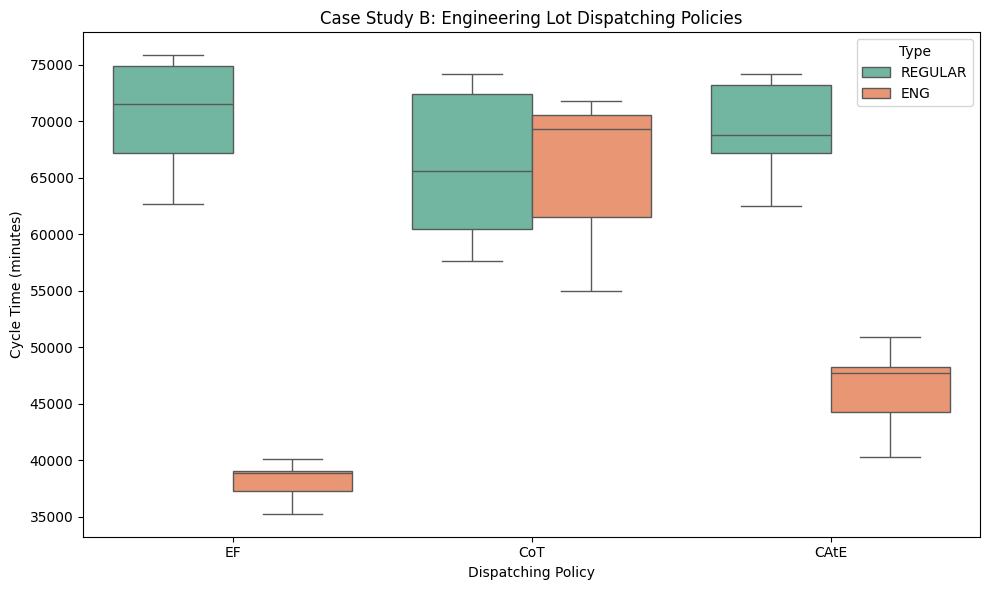

                count        mean          std        min         25%  \
Policy Type                                                             
CAtE   ENG        5.0  46258.6656  4098.551001  40263.440  44253.7220   
       REGULAR   10.0  69433.9912  3967.332308  62501.986  67137.5410   
CoT    ENG        5.0  65613.1220  7147.621007  55000.026  61532.2640   
       REGULAR   10.0  65907.8876  6571.835000  57590.948  60456.8625   
EF     ENG        5.0  38106.2780  1901.447578  35241.384  37265.5880   
       REGULAR   10.0  70623.0896  4879.269308  62671.784  67209.0210   

                      50%         75%        max  
Policy Type                                       
CAtE   ENG      47678.722  48213.7220  50883.722  
       REGULAR  68772.034  73159.7240  74146.210  
CoT    ENG      69268.216  70510.1340  71754.970  
       REGULAR  65595.806  72398.1155  74146.984  
EF     ENG      38829.806  39059.8060  40134.806  
       REGULAR  71480.183  74886.9640  75831.108  


In [2]:
import simpy
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load route data ---
file_path = "SMT_2020_Model_Data_-_LVHM.xlsx"
route_df = pd.read_excel(file_path, sheet_name='Route_Product_1')
steps = route_df[['STEP', 'TOOLGROUP', 'MEAN', 'PROCESSING UNIT']].dropna()
steps['MEAN'] = pd.to_numeric(steps['MEAN'], errors='coerce')

# --- Simulation constants ---
NUM_LOTS = 15
INTER_ARRIVAL_TIME = 20
SETUP_TIME = 5
PM_INTERVAL = 500
PM_DURATION = 30
MTBF = 800
MTTR = 60
SIM_TIME = 100000

BATCH_SIZE = 6
MIN_BATCH = 5
batch_tools = ['Diffusion_FE_125']

def run_case_study_b(policy="EF", eng_ratio=0.2, seed=42):
    global env, lot_times, tool_resources, tool_available, last_operation, batch_queues

    lot_times = {}

    env = simpy.Environment()
    tool_resources = {}
    tool_available = {}
    last_operation = {}
    batch_queues = {}

    for tool in steps['TOOLGROUP'].unique():
        tool_resources[tool] = simpy.PriorityResource(env, capacity=1)
        tool_available[tool] = True
        last_operation[tool] = None
        if tool in batch_tools:
            batch_queues[tool] = []

    def tool_downtime_behavior(env, tool_name):
        while True:
            yield env.timeout(PM_INTERVAL)
            tool_available[tool_name] = False
            yield env.timeout(PM_DURATION)
            tool_available[tool_name] = True
            yield env.timeout(random.expovariate(1.0 / MTBF))
            tool_available[tool_name] = False
            yield env.timeout(random.expovariate(1.0 / MTTR))
            tool_available[tool_name] = True

    for tool in tool_resources:
        env.process(tool_downtime_behavior(env, tool))

    def process_lot_through_route(env, steps, lot_id, lot_type, init_priority, policy):
        lot_times[lot_id] = {'start': env.now, 'end': None, 'type': lot_type}

        for _, row in steps.iterrows():
            tool_name = row['TOOLGROUP']
            proc_time = row['MEAN']
            step_id = row['STEP']
            while not tool_available[tool_name]:
                yield env.timeout(5)

            # Adjust engineering lot priority dynamically for CoT and CAtE
            priority_level = init_priority
            if lot_type == "ENG" and policy in ["CoT", "CAtE"]:
                current_queue = len(tool_resources[tool_name].queue)
                if policy == "CoT" and current_queue <= 2:
                    priority_level = 1
                elif policy == "CAtE":
                    safe_to_cut = True
                    for req in tool_resources[tool_name].queue:
                        if hasattr(req, 'priority') and req.priority <= 1:
                            safe_to_cut = False
                    if safe_to_cut:
                        priority_level = 1

            if tool_name in batch_tools:
                queue = batch_queues[tool_name]
                batch_event = env.event()
                lot_info = (lot_id, lot_type, priority_level, batch_event, step_id)
                queue.append(lot_info)
                if len(queue) >= MIN_BATCH:
                    batch = queue[:BATCH_SIZE]
                    batch_queues[tool_name] = queue[BATCH_SIZE:]
                    with tool_resources[tool_name].request(priority=0) as request:
                        yield request
                        if last_operation[tool_name] != step_id:
                            yield env.timeout(SETUP_TIME)
                            last_operation[tool_name] = step_id
                        yield env.timeout(proc_time)
                        for (bid, btype, _, bevent, _) in batch:
                            if not bevent.triggered:
                                bevent.succeed()
                yield batch_event
            else:
                with tool_resources[tool_name].request(priority=priority_level) as request:
                    yield request
                    if last_operation[tool_name] != step_id:
                        yield env.timeout(SETUP_TIME)
                        last_operation[tool_name] = step_id
                    yield env.timeout(proc_time)

        lot_times[lot_id]['end'] = env.now

    def lot_generator(env):
        for i in range(NUM_LOTS):
            lot_id = f"{policy}_Lot-{i+1:03d}"
            r = random.random()
            if r < eng_ratio:
                lot_type = "ENG"
                if policy == "EF":
                    init_priority = -1
                else:
                    init_priority = 2
            else:
                lot_type = "REGULAR"
                init_priority = 2
            env.process(process_lot_through_route(env, steps, lot_id, lot_type, init_priority, policy))
            yield env.timeout(INTER_ARRIVAL_TIME)

    random.seed(seed)
    env.process(lot_generator(env))
    env.run(until=SIM_TIME)

    rows = []
    for lot_id, times in lot_times.items():
        if times['end'] is not None:
            rows.append({
                "Lot": lot_id,
                "Policy": policy,
                "Type": times['type'],
                "Start": times['start'],
                "End": times['end'],
                "CycleTime": times['end'] - times['start']
            })
    return pd.DataFrame(rows)

# --- Run Case Study B scenarios ---
df_ef = run_case_study_b(policy="EF")
df_cot = run_case_study_b(policy="CoT")
df_cate = run_case_study_b(policy="CAtE")

df_caseB = pd.concat([df_ef, df_cot, df_cate])

# --- Plot results ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_caseB, x="Policy", y="CycleTime", hue="Type", palette="Set2")
plt.title("Case Study B: Engineering Lot Dispatching Policies")
plt.ylabel("Cycle Time (minutes)")
plt.xlabel("Dispatching Policy")
plt.tight_layout()
plt.show()

# --- Summary Stats ---
print(df_caseB.groupby(["Policy", "Type"])["CycleTime"].describe())
